In [0]:
#@title 今回使うものの準備

# GPUを用いて高速に実行できる機械学習ライブラリ
import tensorflow as tf
tf.enable_eager_execution()

# 結果をプロットするためのライブラリ
import matplotlib.pyplot as plt

import numpy as np
layers = tf.keras.layers

# 学習の安定のため、中間層の値を正規化するLayer
class PixelwiseNormalization(tf.keras.layers.Layer):
  def __init__(self):
    super(PixelwiseNormalization, self).__init__()
  
  def call(self, x):
    n = tf.reduce_mean(tf.square(x), -1, keepdims=True)
    n = tf.rsqrt(n + 1e-5)
    return x * n

# ミニバッチ内の特徴量の標準偏差をdiscriminatorの判別基準にするためのLayer
# これによって本物の特徴量が多様ならば、偽物の特徴量も多様になるようにgeneratorが学習するようになる（mode collapse防止）
# Discriminatorの最終層の手前などに入れて使う
class MinibatchStddev(tf.keras.layers.Layer):
  def __init__(self, group_size=1, num_new_features=1):
    super(MinibatchStddev, self).__init__()
    self._group_size = group_size
    self._num_new_features = num_new_features

  def call(self, x):
    s = tf.shape(x) # [NHWC]  Input shape.
    n = self._num_new_features
    G = tf.minimum(self._group_size, s[0])

    # [GMHWnc] Split minibatch into M groups of size G. Split channels into n channel groups c.
    y = tf.reshape(x, [G, -1, s[1], s[2], n, s[3]//n])
    # [MHWnc]  Calc stddev over group.
    y -= tf.reduce_mean(y, axis=0, keepdims=True)
    y = tf.reduce_mean(tf.square(y), axis=0)
    y = tf.sqrt(y + 1e-8)
    # [M11n]  Take average over fmaps and pixels.
    y = tf.reduce_mean(y, axis=[1,2,4], keepdims=True)[:,:,:,:,0]
    # [NHWn]  Replicate over group and pixels.
    y = tf.tile(y, [G, s[1], s[2], 1])
    # [NHWC]  Append as new fmap.
    return tf.concat([x, y], axis=3)

# 畳み込み層ごとの学習率を最適化するための細工 (Karras et al., 2018)
class Conv2D(layers.Conv2D):
  def __init__(self, *args, **kwargs):
    kwargs['kernel_initializer'] = tf.keras.initializers.RandomNormal(stddev=1.)
    super(Conv2D, self).__init__(*args, **kwargs)

  def build(self, input_shape):
    super(Conv2D, self).build(input_shape)
    shape = self.kernel.shape.as_list()
    self._normalization_constant = np.sqrt(2./(shape[0] * shape[1] * shape[2]))
  
  def call(self, x):
    x = x * self._normalization_constant
    x = super(Conv2D, self).call(x)
    return x

In [0]:
# 画像のチャネル数（MNIST、Fashion-MNISTは1、カラー画像は3）
input_channels = 1

In [0]:
#@title データセットの準備

# ここにデータセットを配置する。
# 想定するデータセットはイントロだけでもいいので、
# 「人が確実にワルツ」とわかるだけの音楽長さがあること。

# どーしても見つからないので、波形データのデータセットを用いてみる、と思ったけどなんかエラー
# from keras.datasets import boston_housing
# (x_train_b, y_train_b), (x_test_b, y_test_b) = boston_housing.load_data()




#Fashion-MNIST データセット
import tensorflow_datasets as tfds
#ds = tfds.image.mnist.FashionMNIST()
#ds = tfds.image.mnist.MNIST()

#print(ds)
#print(ds.shape)
#print(ds.type)

#ds.download_and_prepare()
#dataset = ds.as_dataset()['train']

#print(dataset)
#print(dataset.shape)
#print(dataset.type)

#def preprocess(data):
#  img = tf.cast(data['image'], tf.float32)/255. * 2. - 1. #黒を-1.0、白を+1.0とする
#  return tf.image.resize_bilinear([img], (16, 16))[0], data['label']
def preprocess(data):
  img = tf.cast(data['image'], tf.float32)/255. * 2. - 1. #黒を-1.0、白を+1.0とする
  return tf.image.resize_bilinear([img], (1025, 216))[0], data['label']
dataset = dataset.map(preprocess)

print(dataset)
print(dataset.type)


NameError: ignored

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'>
(1025, 216)
[0. 0. 0. ... 0. 0. 0.]
<class 'numpy.ndarray'>


22050
<class 'int'>
[0. 0. 0. ... 0. 0. 0.]
<class 'numpy.ndarray'>


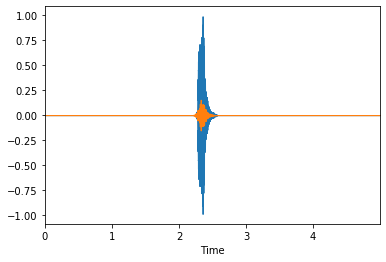

In [0]:
#@title 学習させる画像の作成

# 音声から学習させる画像を生成する
# データセットをダウンロード・読み込みを実施しよう
# 読み込み用のライブラリにlibrosaを使用する
import librosa
import librosa.display

# ひとまず表示。mp4の動画でも取得できた。
from google.colab import drive
drive.mount('/gdrive')

import glob
file_list = sorted(glob.glob('/gdrive/My Drive/gan_workshop/MusicData/ESC-50-master/audio/*.wav'))


# Google Driveから音声ファイル名を取得する
# filename = '/gdrive/My Drive/gan_workshop/MusicData/IMG_3704.mp4'
filename = '/gdrive/My Drive/gan_workshop/MusicData/ESC-50-master/audio/5-263902-A-36.wav'

files = '/gdrive/My Drive/gan_workshop/MusicData/ESC-50-master/audio/*.wav'

# ファイルをロードする。
# yが値。srが周波数だったかな？ 44100 22050
# y, sr = librosa.load(filename, sr=44100, offset=0.0, duration=60.0)
y, sr = librosa.load(file_list[0], sr=22050, offset=0.0, duration=60.0)
librosa.display.waveplot(y=y, sr=sr)

# 【librosaのstft】
S = np.abs(librosa.stft(y))
# librosa.display.specshow(librosa.amplitude_to_db(S**2,ref=np.max),y_axis='log', x_axis='time')
# plt.title('Power spectrogram')
# plt.colorbar(format='%+2.0f dB')
# plt.tight_layout()

print(S)
print(type(S))
print(S.shape)
print(y)
print(type(y))

np.save('/gdrive/My Drive/gan_workshop/MusicData/ESC-50-master/stft_pic/sample_1.npy', S)

# 音の再生には結構準備が必要。音の再生自体はWindows上から行う。
# 一部上げると、pydubモジュールの外にpyaudioモジュールとffmpegとが必要
import IPython.display as ipd
# ipd.display(ipd.Audio(y, rate=sr, autoplay=True)) # load a local WAV file
ipd.display(ipd.Audio(y, rate=sr)) # load a local WAV file

# データとしてとりあえず保存してる
# csvとかでいいので、データを保存すること。
# それを読み込めば、変換した状態になるので、
#すぐに食わせることができる。


# 画像のサイズを変更する必要がある。

# 逆STFTして再生してみる。
z1 = librosa.istft(S, dtype=y.dtype)
librosa.output.write_wav('test2.wav', z1, sr)
ipd.display(ipd.Audio(z1, rate=sr))

librosa.display.waveplot(y=z1, sr=sr)

print(sr)
print(type(sr))
print(z1)
print(type(z1))

'''
import pydub
from pydub.playback import play

sound = pydub.AudioSegment.from_wav(filename)
play(sound)
'''


# 手法はSTFT（またはWavelet変換）を採用する
# イメージとしては、ワルツっぽい音の画像を作成し、
# そのイメージ画像を学習させることで
# ワルツっぽい画像を作るGeneratorを作成する。
# これによって作成された画像を逆STFTすることで
# 音データに戻し、ちゃんと聞くことができるのかやってみる！

# 
from scipy import signal

# TODO 思いついた課題ややる必要があること
# 作った画像データをまとめて、データセットとする
# データの正規化

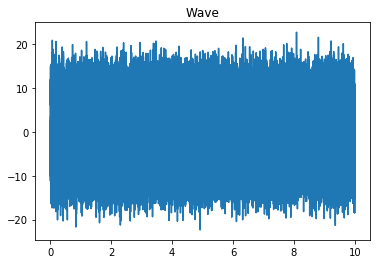

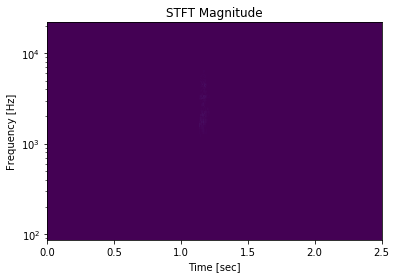

In [0]:
#@ STFTの例。取り合ず表示するならここを実行する
#Generate a test signal, a 2 Vrms sine wave at 50Hz corrupted by 0.001 V**2/Hz of white noise sampled at 1024 Hz.
#テスト信号、1024 Hzでサンプリングされた0.001 V ** 2 / Hzのホワイトノイズで破損した50 Hzの2 Vrmsの正弦波を生成します
from scipy import signal

# サンプリング周波数
fs = 44100
# fs = 1024

# サンプリングする点数
N = 10*fs

# 窓関数の周波数。大きすぎてもだめ。
# nperseg = fs/2
nperseg = 512

# アンプリチュード？
amp = 2 * np.sqrt(2)

# ノイズを作成 大きいと生成される画像にノイズが表示されていく
# noise_power = 800.0
noise_power = 0.001 * fs / 2

time = np.arange(N) / float(fs)
carrier = amp * np.sin(2*np.pi*50*time)
noise = np.random.normal(scale=np.sqrt(noise_power),
                         size=time.shape)
x = carrier + noise
#Compute and plot the STFT’s magnitude.
#STFTの振幅を計算してプロットします
plt.figure()
plt.plot(time, x)
plt.title('Wave')
plt.show()

# mp4から取得したデータを変換してみる
# そもそも波形データ作るのがむずいぞー。。。
'''
f, t, Zxx = signal.stft(y, fs=fs, nperseg=nperseg)
plt.figure()
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp)
plt.ylim([f[1], f[-1]])
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.show()
'''

# STFT
f, t, Zxx = signal.stft(y, fs=fs, nperseg=nperseg)
plt.figure()
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp)
plt.ylim([f[1], f[-1]])
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.show()



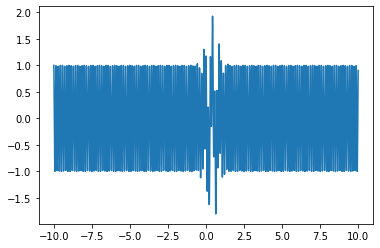

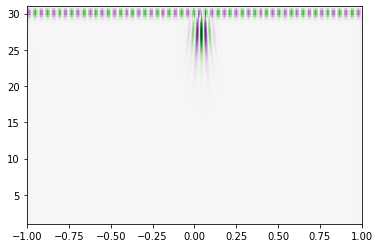

In [0]:
#@ Wavelet変換の例
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from scipy import signal
import matplotlib.pyplot as plt
t = np.linspace(-10, 10, 2000, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)

#**以下二行追加**
plt.plot(t,sig)
plt.pause(3)
#******

widths = np.arange(1, 101)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

In [0]:
#@title ラベル付けを行う
import pandas as pd

# DataFrame型で読み込む
df = pd.read_csv('/gdrive/My Drive/gan_workshop/MusicData/ESC-50-master/stft_pic/esc50_meta.csv', index_col=0)

# カテゴリーの部分を抽出し、dictionary型に変換する
categories = df['category'].to_dict()

# ファイル名がどのカテゴリーなのかわかる
print(categories['1-100210-B-36.wav'])

# ファイルのdictができれば、
# データ取得時に合わせてリスト化できるのでは？
d = {'dog': 1}
labels = []
for value in categories.values():
  fname = str(value)
  number = 0
  if fname == 'dog':
    number = 1
  elif fname == 'chirping_birds':
    number = 2
  elif fname == 'vacuum_cleaner':
    number = 3
  elif fname == 'thunderstorm':
    number = 4
  elif fname == 'door_wood_knock':
    number = 5
  elif fname == 'can_opening':
    number = 6
  elif fname == 'crow':
    number = 7
  elif fname == 'clapping':
    number = 8
  elif fname == 'fireworks':
    number = 9
  elif fname == 'chainsaw':
    number = 10
  elif fname == 'airplane':
    number = 11
  elif fname == 'mouse_click':
    number = 12
  elif fname == 'pouring_water':
    number = 13
  elif fname == 'train':
    number = 14
  elif fname == 'sheep':
    number = 15
  elif fname == 'water_drops':
    number = 16
  elif fname == 'church_bells':
    number = 17
  elif fname == 'clock_alarm':
    number = 18
  elif fname == 'keyboard_typing':
    number = 19
  elif fname == 'wind':
    number = 20
  elif fname == 'footsteps':
    number = 21
  elif fname == 'frog':
    number = 22
  elif fname == 'cow':
    number = 23
  elif fname == 'brushing_teeth':
    number = 24
  elif fname == 'car_horn':
    number = 25
  elif fname == 'crackling_fire':
    number = 26
  elif fname == 'helicopter':
    number = 27
  elif fname == 'drinking_sipping':
    number = 28
  elif fname == 'rain':
    number = 29
  elif fname == 'insects':
    number = 30
  elif fname == 'laughing':
    number = 31
  elif fname == 'hen':
    number = 32
  elif fname == 'engine':
    number = 33
  elif fname == 'breathing':
    number = 34
  elif fname == 'crying_baby':
    number = 35
  elif fname == 'hand_saw':
    number = 36
  elif fname == 'coughing':
    number = 37
  elif fname == 'glass_breaking':
    number = 38
  elif fname == 'snoring':
    number = 39
  elif fname == 'toilet_flush':
    number = 40
  elif fname == 'pig':
    number = 41
  elif fname == 'washing_machine':
    number = 42
  elif fname == 'clock_tick':
    number = 43
  elif fname == 'sneezing':
    number = 44
  elif fname == 'rooster':
    number = 45
  elif fname == 'sea_waves':
    number = 46
  elif fname == 'siren':
    number = 47
  elif fname == 'cat':
    number = 48
  elif fname == 'door_wood_creaks':
    number = 49
  elif fname == 'crickets':
    number = 50
  d[fname] = number
  labels.append(number)


# print(d) 
# print(labels)
# read_s = np.load('/gdrive/My Drive/gan_workshop/MusicData/ESC-50-master/stft_pic/esc50_meta.csv')

# print(read_s(1))

vacuum_cleaner


In [0]:
#@title データの読み込み
import glob

FILE_NAME = '1-100032-A-0'
read_s = np.load('/gdrive/My Drive/gan_workshop/MusicData/ESC-50-master/stft_pic/sample_'+FILE_NAME +'.npy')

# *.wavファイルを配置しているパス
WAV_FILES_PATH = '/gdrive/My Drive/gan_workshop/MusicData/ESC-50-master/stft_pic/*.npy'

# 一応ファイル名順でソートして取得し、リスト変数に格納
file_list = sorted(glob.glob(WAV_FILES_PATH))

# datasetの作成
# データセットの作成に失敗しているはず。とりあえずone_shotで学習ができているのか確認する
dataset = tf.data.Dataset.from_tensor_slices(file_list, labels)

def _parse_fn(filename):
  category = str(file_list).replace('.wav', '')
  sound_img = np.load(file_list[0])
  return tf.image.resize_bilinear([sound_img], (1025, 216))[0], labels

dataset = dataset.map(_parse_fn)

print(dataset)
# read_s = np.load(file_list[0])
# print(read_s)
# print(read_s.shape)
'''
for file_name in categories:
  fname = str(file_name).replace('.wav', '')
  print(fname)
  read_s = np.load('/gdrive/My Drive/gan_workshop/MusicData/ESC-50-master/stft_pic/sample_'+ fname +'.npy')

print(read_s)
print(read_s.shape)
'''


TypeError: ignored

In [0]:
#@title データセットの作成

# filename（ただのファイル名のリスト）
# 正規表現でもよいみたい
filenames = glob.glob(DATA_DIR) 

# filenamesからデータセットを作成する
# Datasetオブジェクトを作る
dataset = tf.data.Dataset.from_tensor_slices(filenames)

# 他にも，対応したラベルとかがあるんだったら，
# 次みたいにタプルにして渡してあげればよしなにやってくれます．
# dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

In [0]:
#@title Generatorの作成

# 1,1,128のサイズのデータを渡してあげることで、
# 任意のサイズの画像を作ることができる
# 　

# noise_dim = 128
noise_dim = 128

generator = tf.keras.Sequential([
    # 入力してるサイズ 1025*216
    Conv2D(256, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    PixelwiseNormalization(),

    layers.UpSampling2D(2),
    Conv2D(128, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    PixelwiseNormalization(),

    layers.UpSampling2D(2),
    Conv2D(64, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    PixelwiseNormalization(),

    layers.UpSampling2D(2),
    Conv2D(32, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    PixelwiseNormalization(),

    layers.UpSampling2D(2),
    Conv2D(16, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    PixelwiseNormalization(),

    Conv2D(input_channels, [1,1], 1, 'SAME', use_bias=True),

    # Activationも活性化関数を指定しているだけ？
    layers.Activation('tanh')
  ])

In [0]:
#@title 画像の丸暗記

generator.compile(tf.train.AdamOptimizer(0.001), loss='mean_squared_error')

# inputs = tf.one_hot(tf.range(noise_dim), noise_dim) # tf.one_hot(i)はe[i]だけ1.で他が0.のベクトル（つまり単位ベクトル）を生成
# inputs = tf.reshape(inputs, [noise_dim, 1, 1, noise_dim])
# for x, y in dataset.batch(noise_dim).take(1):
#   image = x

# 【メモ】
# tf.one_hot(i)はe[i]だけ1.で他が0.のベクトル（つまり単位ベクトル）を生成
# one_hotは一つの要素のみ値を持ち、
# ほかの要素は0となる単位ベクトル（単位行列）
# 第1引数（indices）に指定した場所の要素が値を持つ
# 例）indices = 2とした場合、(0,1,0,0,0,・・・)
# 第2引数（depth）が長さを設定する。

inputs = tf.one_hot(tf.range(noise_dim), noise_dim)
inputs = tf.reshape(inputs, [noise_dim, 1, 1, noise_dim])


for x, y in dataset.batch(2).take(1):
  image = x

In [0]:
generator.fit(x=inputs, y=image, epochs=10, verbose=0)


InvalidArgumentError: ignored

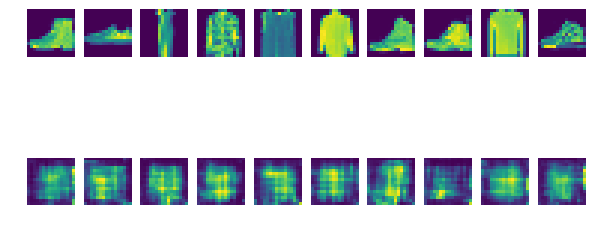

In [0]:
#@title 正解画像と生成画像を比較
y = generator(inputs)
plt.figure(figsize=(10,5))
n = 10
for i in range(n):
  plt.subplot(2,n,i+1)
  plt.imshow(image[i,:,:,0])
  plt.axis('off')
  plt.subplot(2,n,n+i+1)
  plt.imshow(y[i,:,:,0])
  plt.axis('off')

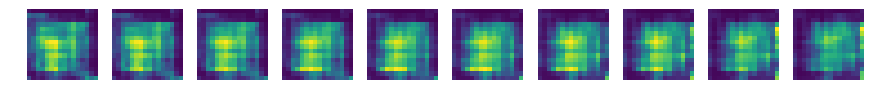

In [0]:
#@title 入力を徐々に変化させてみる
import numpy as np
i1 = 0
i2 = 1
n = 10

x = np.zeros([n,1,1,noise_dim], np.float32)
x[:,0,0,i1] = np.linspace(0.,1.,n)
x[:,0,0,i2] = np.linspace(1.,0.,n)
y = generator(tf.constant(x))
plt.figure(figsize=(15,5))
for i in range(n):
  plt.subplot(1,n,i+1)
  plt.imshow(y[i,:,:,0])
  plt.axis('off')

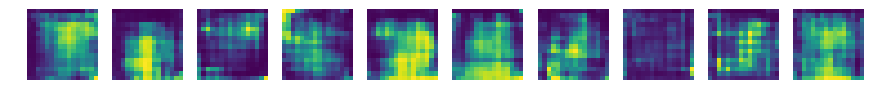

In [0]:
#@title 任意の乱数について意味のある画像を生成できるか？
n = 10
y = generator(tf.random.normal([n,1,1,noise_dim]))
plt.figure(figsize=(15,5))
for i in range(n):
  plt.subplot(1,n,i+1)
  plt.imshow(y[i,:,:,0])
  plt.axis('off')

---

In [0]:
#@title Discriminatorの構成

discriminator = tf.keras.Sequential([
    Conv2D(16, [1,1], 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),

    Conv2D(32, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    layers.AveragePooling2D(2),
    
    Conv2D(64, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    layers.AveragePooling2D(2),
    
    Conv2D(128, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    layers.AveragePooling2D(2),

    Conv2D(256, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    layers.AveragePooling2D(2),

    Conv2D(1, 3, 1, 'SAME', use_bias=False)
])

In [0]:
#@title 本物と偽物を判別させてみる

discriminator.compile(tf.train.AdamOptimizer(0.001), loss='binary_crossentropy')

for x, y in dataset.batch(10000).take(1):
  real = x
fake = generator(tf.random.normal([10000,1,1,noise_dim]))
inputs = tf.concat([real, fake], 0)
outputs = tf.concat([tf.ones([10000,1,1,1]), tf.zeros([10000,1,1,1])], 0)

InvalidArgumentError: ignored

In [0]:
discriminator.fit(x=inputs, y=outputs, epochs=10, verbose=0)

In [0]:
#@title Discriminatorの出力
for x, y in dataset.batch(1000).take(1):
  d_real = discriminator(x)
  d_fake = discriminator(generator(tf.random.normal([1000,1,1,noise_dim])))
  plt.hist(d_real[:,0,0,0], label='real')
  plt.hist(d_fake[:,0,0,0], label='fake')
  
# 出力された結果がかぶっていなければ、本物と偽物を見分けることができているといえる。
# 逆に言うと、このgeneratorはまだそのレベルのものしか生成できていない。

---

In [0]:
#@title Generatorとdiscriminatorを戦わせる

def f(x):
  return x

# クロスエントロピーでフィッティングする場合
#def f(x):
#  return -tf.log1p(tf.exp(-x))

@tf.contrib.eager.defun #これをつけた関数は最初の呼び出し時に最適化される
def train_step(real, noise):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    fake = generator(noise)

    d_real = discriminator(real)
    d_fake = discriminator(fake)

    loss = f(d_real) + f(-d_fake)
    g_loss = tf.reduce_mean(loss)
    d_loss = tf.reduce_mean(-loss)

  g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
  d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
  g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
  d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))
  return d_loss

g_opt = tf.train.AdamOptimizer(0.0002)
d_opt = tf.train.AdamOptimizer(0.0002)
epoch = 0

In [0]:
#@title 実行（エラーが出ないことを確認してバックグラウンドで実行する）
import time

for i in range(5):
  t0 = time.time()
  for x, y in dataset.shuffle(1000).batch(128):
    loss = train_step(x, tf.random.normal([x.shape[0],1,1,noise_dim]))
  t1 = time.time()
  print("Epoch {}: loss={}, took {} sec.".format(epoch, loss.numpy(), t1-t0))
  epoch += 1

In [0]:
#@title バックグラウンドで実行

import time
import threading

def train():
  for i in range(5):
    t0 = time.time()
    for x, y in dataset.shuffle(1000).batch(128):
      loss = train_step(x, tf.random.normal([x.shape[0],1,1,noise_dim]))
    t1 = time.time()
    print("Epoch {}: loss={}, took {} sec.".format(epoch, loss.numpy(), t1-t0))
    epoch += 1

thread = threading.Thread(target=train)
thread.start()

In [0]:
#@title MCを避けるためにquadratic_potentialの制約をかける
# Dの傾きを求める
# これを小さくするようにdiscriminatorに制約をかける
def quadratic_potential(dx, dy, _lambda=.01, _epsilon=1e-8, norm='L2'):
  norm = norm.lower()
  if norm == 'l1':
    dx = tf.abs(dx)
  elif norm == 'l2':
    dx = tf.square(dx)
  else:
    raise ValueError('Unknown norm type: {}'.format(norm))

  dx = tf.reduce_mean(tf.reshape(dx, [tf.shape(dx)[0],-1]))
  if norm == 'l2':
    dx = tf.sqrt(dx)

  return tf.square(dy)/(dx*2*_lambda + _epsilon)

@tf.contrib.eager.defun #これをつけた関数は最初の呼び出し時に最適化される
def train_step(real, noise):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    fake = generator(noise)

    d_real = discriminator(real)
    d_fake = discriminator(fake)

    loss = f(d_real) + f(-d_fake)
    g_loss = tf.reduce_mean(loss)
    d_loss = tf.reduce_mean(-loss + quadratic_potential(fake-real, d_fake-d_real))

  g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
  d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
  g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
  d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))
  return d_loss

epoch = 0
g_opt = tf.train.AdamOptimizer(0.0002)
d_opt = tf.train.AdamOptimizer(0.0002)

In [0]:
#@title Googleドライブにgeneratorを保存

from google.colab import drive
drive.mount('/gdrive')

generator.save_weights('/gdrive/My Drive/gan_workshop/Musicgenerator')

In [0]:
#@title Googleドライブからgeneratorを読み込み

from google.colab import drive
drive.mount('/gdrive')

generator.load_weights('/gdrive/My Drive/gan_workshop/Musicgenerator')